# Local Volatility Model


The local volatility model is a deterministic volatility model where the volatility of an asset depends on both the underlying asset price and time. It extends the Black-Scholes model. It provides a better fit to observed market prices, for different strikes and maturities, by capturing the volatility smile, ensuring arbitrage-free pricing. The model is primarily used for exotic options pricing and volatility surface calibration, with the local volatility function derived using Dupire’s equation from market-implied volatilities.

The Local Volatility Model allows volatility to be a function of both time and moneyness  $\sigma_{loc}(S, t)$. It provides a way to construct a volatility surface directly from market option prices without assuming a specific stochastic process.

Key Advantages:
- Can be calibrated to perfectly fit market-implied volatility surfaces 
- Captures term structure and moneyness dependence of volatility
- Better pricing of exotic options (barriers, cliquets, forward-start options).

## Theory: Dupire’s Local Volatility Formula

Given a set of market-implied volatilities  $\sigma_{imp}(K, T) $, Dupire’s formula allows us to compute the local volatility function  $\sigma_{loc}(S, t)$ :


$$\sigma_{loc}^2(K, T) = \frac{\frac{\partial C}{\partial T} + rK \frac{\partial C}{\partial K}}{\frac{1}{2} K^2 \frac{\partial^2 C}{\partial K^2}}$$


where:
- $C(K, T$)  is the market price of a European call with strike  K  and maturity  T .
- $\frac{\partial C}{\partial T}$  is the time derivative of the call price.
- $\frac{\partial C}{\partial K}$  and  $\frac{\partial^2 C}{\partial K^2}$  are the first and second derivatives with respect to strike.

Interpretation:
- This formula tells us how the implied volatility surface evolves locally at each point.
- The result is a non-parametric, arbitrage-free volatility model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp2d, griddata
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
class LocalVolatilityModel:
    def __init__(self, S0, r, dividend_yield=0):
        """
        Initialize Local Volatility Model
        
        Parameters:
        S0: Initial stock price
        r: Risk-free rate
        dividend_yield: Dividend yield
        """
        self.S0 = S0
        self.r = r
        self.q = dividend_yield
        
    def black_scholes_call(self, S, K, T, sigma):
        """Black-Scholes call option price"""
        from scipy.stats import norm
        
        d1 = (np.log(S/K) + (self.r - self.q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        call_price = S*np.exp(-self.q*T)*norm.cdf(d1) - K*np.exp(-self.r*T)*norm.cdf(d2)
        return call_price
    
    def black_scholes_vega(self, S, K, T, sigma):
        """Vega of Black-Scholes option"""
        from scipy.stats import norm
        
        d1 = (np.log(S/K) + (self.r - self.q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        vega = S*np.exp(-self.q*T)*norm.pdf(d1)*np.sqrt(T)
        return vega
    
    def implied_volatility(self, market_price, S, K, T):
        """Calculate implied volatility using Newton-Raphson method"""
        sigma = 0.2  # Initial guess
        tolerance = 1e-6
        max_iterations = 100
        
        for i in range(max_iterations):
            price = self.black_scholes_call(S, K, T, sigma)
            vega = self.black_scholes_vega(S, K, T, sigma)
            
            if abs(vega) < 1e-10:
                break
                
            diff = market_price - price
            if abs(diff) < tolerance:
                break
                
            sigma += diff / vega
            sigma = max(sigma, 0.01)  # Ensure positive volatility
            
        return sigma

In [3]:
# Initialize model parameters
S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
q = 0.02  # Dividend yield

model = LocalVolatilityModel(S0, r, q)

In [4]:
def create_sample_iv_surface():
    """Create a sample implied volatility surface for demonstration"""
    
    # Define strikes and maturities
    strikes = np.linspace(80, 120, 20)
    maturities = np.linspace(0.1, 2.0, 15)
    
    K_grid, T_grid = np.meshgrid(strikes, maturities)
    
    # Create a realistic volatility smile/surface
    # Vol smile with term structure
    moneyness = K_grid / S0
    iv_surface = 0.2 + 0.1 * (moneyness - 1)**2 + 0.05 * np.exp(-T_grid)
    
    return strikes, maturities, K_grid, T_grid, iv_surface

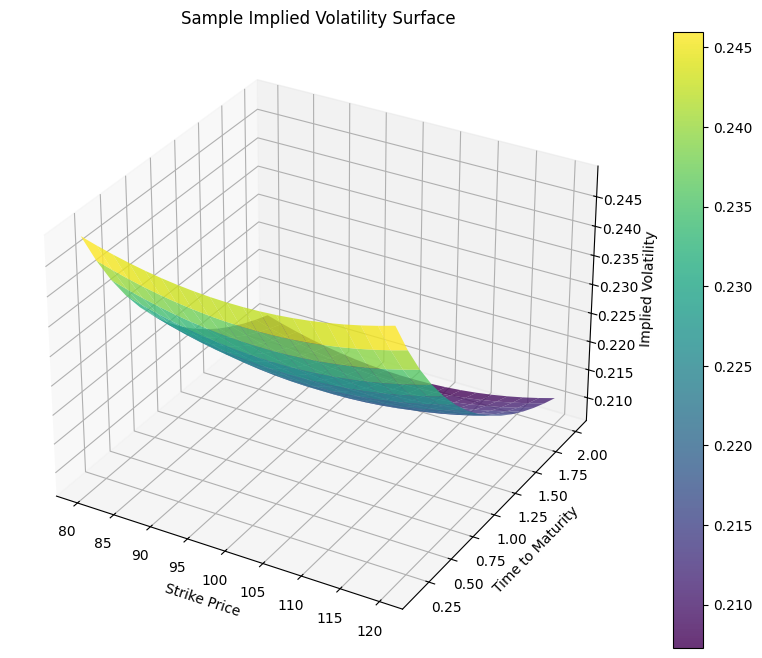

In [5]:
strikes, maturities, K_grid, T_grid, iv_surface = create_sample_iv_surface()

# Plot the implied volatility surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_grid, T_grid, iv_surface, cmap='viridis', alpha=0.8)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Sample Implied Volatility Surface')
plt.colorbar(surf)
plt.show()

In [7]:
def calculate_local_volatility_dupire(strikes, maturities, iv_surface, S0, r, q):
    """
    Calculate local volatility using Dupire's formula
    """
    # Calculate call prices from implied volatilities
    K_grid, T_grid = np.meshgrid(strikes, maturities)
    call_prices = np.zeros_like(iv_surface)
    
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            sigma_iv = iv_surface[i, j]
            call_prices[i, j] = model.black_scholes_call(S0, K, T, sigma_iv)
    
    # Calculate derivatives numerically
    dK = strikes[1] - strikes[0]
    dT = maturities[1] - maturities[0]
    
    # First derivatives
    dC_dT = np.gradient(call_prices, dT, axis=0)
    dC_dK = np.gradient(call_prices, dK, axis=1)
    
    # Second derivative with respect to K
    d2C_dK2 = np.gradient(dC_dK, dK, axis=1)
    
    # Dupire's formula
    numerator = dC_dT + r * K_grid * dC_dK
    denominator = 0.5 * K_grid**2 * d2C_dK2
    
    # Avoid division by zero
    denominator = np.where(np.abs(denominator) < 1e-10, 1e-10, denominator)
    
    local_var = numerator / denominator
    local_vol = np.sqrt(np.maximum(local_var, 0.01))  # Ensure positive volatility
    
    return local_vol

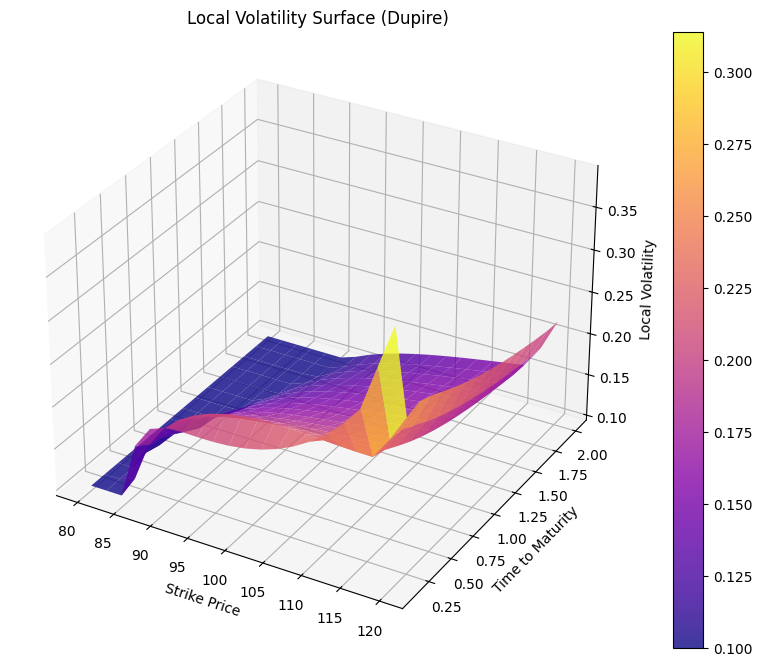

In [8]:
# Calculate local volatility surface
local_vol_surface = calculate_local_volatility_dupire(strikes, maturities, iv_surface, S0, r, q)

# Plot local volatility surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_grid, T_grid, local_vol_surface, cmap='plasma', alpha=0.8)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Local Volatility')
ax.set_title('Local Volatility Surface (Dupire)')
plt.colorbar(surf)
plt.show()